In [1]:
import os
import random

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
import tensorboard

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)

import pandas as pd
import utils
from model_config import config
from vae import VAEModel
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

random.seed = 46
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Get Michael's data
raw_file = []
with open("caption_for_vae.txt", "r") as f:
    for x in f:
        raw_file.append(x)
        
lyrics = []
for content in raw_file:
    if content[0] != "[":
        content = content.replace(' \n', '\n')
        lyrics.append(content)

random.shuffle(lyrics)
len(lyrics)

284809

In [3]:
# Get a list of sentences [sentence 1 \n, sentence2....]
# lyrics = utils.get_sentences(file_path = 'data/7-selected-no-labels.txt')

print('[INFO] Number of sentences in Lyrics = {}'.format(len(lyrics)))

df = pd.DataFrame(lyrics, columns=['sentence'])
df['label'] = 0

sentences = []
for sent in df['sentence']:
    sentences.append(utils.clean_sentence(sent))   # clean_sentence: regex to make lower case; num--><NUM> token

df['sentence'] = sentences
df = df.sample(frac=1).reset_index(drop=True)    # for visuliaztion purpose
df.head(15)

[INFO] Number of sentences in Lyrics = 284809


,sentence,label
0,a pink framed bicycle resting against an arcad...,0
1,birds fly close to the ground where a sheep is...,0
2,a group of people getting on a small plane.,0
3,wooden train passing through a forested hilly ...,0
4,three statues positioned near a fountain in a ...,0
5,a neatly decorated room with a piano and suspe...,0
6,a large cheese pizza with a meat topping.,0
7,several boats docked on the shore near a mount...,0
8,a surfer riding a large wave on his surf board.,0
9,a group of people with uniforms playing with a...,0


In [4]:
print('[INFO] Tokenizing input and output sequences')
filters = '!"#$%&()*+/:;<=>@[\\]^`{|}~\t\n'
labels = list(df['label'])


# output x is a list of indices. word2index produced by nltk tokenizer
x, word_index = utils.tokenize_sequence(sentences,
                                             filters,
                                             config['num_tokens'],
                                             config['vocab_size'])

print('[INFO] Split data into train-validation-test sets')
x_train, _x_val_test, train_labels, _val_test_labels = train_test_split(x, labels, test_size = 0.1, random_state = 10)
x_val, x_test, val_labels, test_labels = train_test_split(_x_val_test, _val_test_labels, test_size = 0.5, random_state = 10)

# this will use the pre-trained emb from other tasks
if config['use_pre_trained']:
    w2v = config['pre_trained_path']
# this will use amazon word emb
else:
    w2v = config['w2v_file']

'''
embedding_matrix is originally a list of np.random.uniform(-0.05, 0.05, size=(len(word_index), embedding_dim))
And then for each word we get 
            embeddings_vector = w2v_model[word]
            embeddings_matrix[i] = embeddings_vector
This might not be useful for music embedding training. But the initialize process does.
'''    
embeddings_matrix = utils.create_embedding_matrix(word_index,
                                                  config['embedding_size'],
                                                  w2v)

# Re-calculate the vocab size based on the word_idx dictionary
config['vocab_size'] = len(word_index)

[INFO] Tokenizing input and output sequences
[INFO] Split data into train-validation-test sets


In [5]:
model = VAEModel(config, 
                 embeddings_matrix,
                 word_index)

[INFO] Building Model ...


In [6]:
model.train(x_train, x_val)

[INFO] Training process started
Epoch   1/50 - Time  485.2 BLEU: 62.35 | 46.15 | 36.1 | 28.29
Epoch   2/50 - Time  490.0 BLEU: 47.13 | 29.03 | 19.59 | 13.39
Epoch   3/50 - Time  491.0 BLEU: 48.24 | 30.3 | 20.82 | 14.43
Epoch   4/50 - Time  491.6 BLEU: 49.06 | 31.4 | 21.77 | 15.2
Epoch   5/50 - Time  492.4 BLEU: 50.18 | 32.42 | 22.75 | 16.1
Epoch   6/50 - Time  492.2 BLEU: 51.37 | 33.51 | 23.63 | 16.74
Epoch   7/50 - Time  492.9 BLEU: 52.18 | 34.52 | 24.66 | 17.68
Epoch   8/50 - Time  493.2 BLEU: 52.59 | 35.22 | 25.27 | 18.19
Epoch   9/50 - Time  493.3 BLEU: 53.49 | 36.17 | 26.2 | 18.96
Epoch  10/50 - Time  493.8 BLEU: 54.05 | 36.85 | 26.88 | 19.68
Epoch  11/50 - Time  494.2 BLEU: 54.26 | 37.17 | 27.21 | 19.95
Epoch  12/50 - Time  494.5 BLEU: 54.63 | 37.77 | 27.91 | 20.65
Epoch  13/50 - Time  494.4 BLEU: 54.66 | 38.01 | 28.16 | 20.85
Epoch  14/50 - Time  495.4 BLEU: 54.9 | 38.11 | 28.22 | 20.91
Epoch  15/50 - Time  494.9 BLEU: 54.67 | 37.65 | 27.73 | 20.44
Epoch  16/50 - Time  496.2 BLE

### Notes
- Using embeddings pre-trained on other corpus gives lower BLEU
- Using embeddings trainable=True is not very useful
- No effect (total loss still keeps increasing after 1500 iters) on removing/changing lstm dropout 
- After 2500 iterations, KL loss starts dipping
- After 1500 iterations, total loss starts to increase
- Tried a different kl weight anneal schedule<br>
<code>from scipy.stats import logistic<br>
logistic.cdf(iter_i/4500) - 0.5</code><br>
Doesn't work since the annealing has to be done very very slowly 

In [6]:
config['load_checkpoint'] = 50

In [7]:
if config['load_checkpoint'] != 0: 
    checkpoint = config['model_checkpoint_dir'] + str(config['load_checkpoint']) + '.ckpt'
else:
    checkpoint = tf.train.get_checkpoint_state(os.path.dirname('models/checkpoint')).model_checkpoint_path
    
preds = model.predict(checkpoint, x_test)

INFO:tensorflow:Restoring parameters from models/lyrics-50.ckpt
BLEU 1 to 4 : 53.29 | 36.54 | 27.08 | 20.13


In [ ]:
# WHAT'S THIS
model.get_diversity_metrics(checkpoint, x_test[:1000], num_samples=10, num_iterations=1)

In [9]:
lb = 51
ub = 100
# count = 50
model.show_output_sentences(preds[lb:ub], 
                            x_test[lb:ub], 
                            )

A: a group of sheep in a field with a fence in the background .
G: a group of cows in a field with a hand in the traffic

A: a small baby sleeping on a few blankets ,
G: a small dog laying on a bed with spectators

A: a fishtank sitting above a toilet bowl in a bathroom
G: a cat sitting in a bathroom sink in a bathroom

A: a person sitting behind a table with a teddy bear , cellphone and a couple
G: a little boy sitting in a desk with a bear computer and a bear .

A: round pizza on a black and white checkered tablecloth
G: a pizza sitting on a table near green bananas

A: a man is falling on his back while snowboarding .
G: a man is looking at the beach with sheep .

A: two guys are outside moving a refrigerator
G: person luggage bags are sitting on a table

A: four men stand behind a couch playing a video game .
G: two men playing a game of food inside a kitchen .

A: a black and white cat a chair and some bicycles
G: a black and white cat in a car and chair

A: in rail station a cloc

In [10]:
model.random_sample(checkpoint)

INFO:tensorflow:Restoring parameters from models/lyrics-50.ckpt
G: a skateboarder hanging on a pole pole at a building .
G: a man holding a large bird standing over the water .
G: a passenger train parked with a train in a station .
G: a prepares in a kitchen with a refrigerator in it .
G: pizza in a box with a red box and a coffee cup .
G: a woman sitting on a table with a bag of food .
G: two women tan face and wearing a tie .
G: two people holding up a cell phone while in the traffic
G: a baseball player is in the patterned of a large baseball game .
G: a man sits on a bench with a colorful frisbee .
G: a man looking at a camera while holding an umbrella .
G: a young girl holds a pair of scissors .
G: a cat is laying with rock on the floor .
G: a man and woman sitting on top of a table with stuffed animals .
G: a pair of scissors sits on top of a table
G: a some riding a skateboard with person luggage bags .
G: a small bathroom with white touching and toilet seat .
G: the cow is sta

In [11]:
model.linear_interpolate(checkpoint, num_samples=10)

INFO:tensorflow:Restoring parameters from models/lyrics-50.ckpt

G: some sitting in front of a bear with a bag of a banana
G: some sitting in front of a large box of donuts on the table
G: a man sitting on a table in front of a car
G: a man sitting on a bench in front of a car
G: a man on top of a motorcycle in front of a building
G: a man on top of a motorcycle parked at the grass
G: a man on a bike on a bike of person grass
G: a couple of people on a bike down a large building
G: a couple of horses on a field of an old building
G: a couple of horses on a field of grass together

G: a man in a suit and tie sitting on smiling .
G: a man sits in a chair while talking on phone .
G: a man sits in a chair talking on his phone .
G: a man sits on a bench talking in his plane .
G: a man sits on a bench talking in his plane .
G: a man sits on a bench talking on his cell phone .
G: a man is holding a skateboard on the cement filled .
G: a white cat sits on a cluttered in the play traffic .
G: a

In [12]:
model.get_neighbourhood(checkpoint, x_test[200::220], temp = 3.0)

INFO:tensorflow:Restoring parameters from models/lyrics-50.ckpt

A: a white toilet next to a tub and a sink inside of a bathroom .
G: a woman sleeping next to a dog and a dog on a bed .
G: two of background lights on a city street in front of a building .
G: a small white toilet next to a sink next to a toilet .
G: a some with scissors and scissors cutting a white toothbrush in a bathroom .
G: two pizzas on a table that is in a bowl of a coffee cup .
G: a bear is sitting under a table , a cup of coffee .
G: a cat looking up open a window and a window and a window .
G: a white boat next to a body of water with a body of water .
G: a glass window with a sink sitting on top of a window .
G: a sandwich sitting next to a plate of food next to the table .

A: a pair of zebras standing in a dry brush field .
G: a couple of giraffe standing in a large field .
G: a black bird is in the sky on a green slope .
G: a herd of elephants standing together in a river .
G: a man is standing in a snow co

In [13]:
z_vecs = model.get_zvector(checkpoint, x_test)
z_vecs.shape # 100-d vectors

INFO:tensorflow:Restoring parameters from models/lyrics-50.ckpt


(14200, 100)

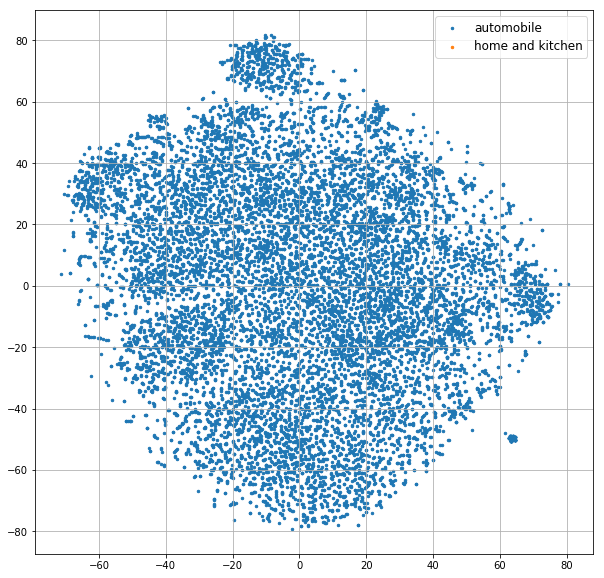

In [14]:
utils.plot_2d(z_vecs, test_labels, method='tsne')